## Week 06 - Decision Trees and Ensemble Learning

By Jorge Abrego

### Getting the dataset

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -P ./data

--2023-10-22 18:08:14--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: './data/housing.csv.4'

housing.csv.4       100%[===================>]   1.36M  --.-KB/s    in 0.006s  

2023-10-22 18:08:14 (214 MB/s) - './data/housing.csv.4' saved [1423529/1423529]



### Loading libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import time
#import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from tqdm import tqdm

%matplotlib inline
#warnings.filterwarnings("ignore")

### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [3]:
data = pd.read_csv('data/housing.csv')
selected_houses = ['<1H OCEAN', 'INLAND']
df = data[data['ocean_proximity'].isin(selected_houses)].copy()

In [4]:
df['ocean_proximity'].replace({'<1H OCEAN':'LT 1H OCEAN'}, inplace=True)

In [5]:
df.isna().sum()[df.isna().sum()>0]

total_bedrooms    157
dtype: int64

In [6]:
df['total_bedrooms'].fillna(0, inplace=True)

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [8]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [9]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

### Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.

Which feature is used for splitting the data?

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=LT 1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=LT 1H OCEAN >  0.50
|   |--- value: [12.30]



In [12]:
print("ocean_proximity is used for splitting the data")

ocean_proximity is used for splitting the data


### Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

In [13]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [14]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24436206729166104

### Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

In [15]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
    scores.append((n, score))
    time.sleep(0.1)

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


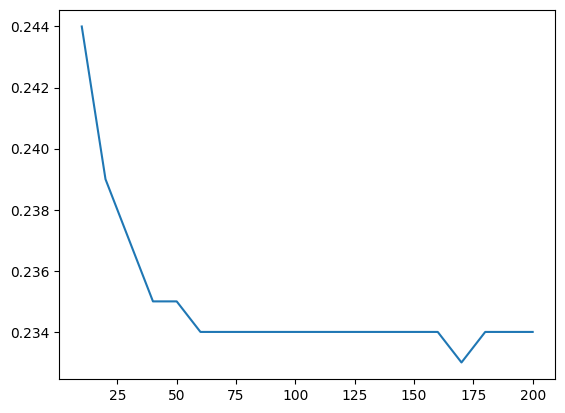

In [16]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

### Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

In [17]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)
    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((d, n, score))
    time.sleep(0.1)

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

100%|██████████| 4/4 [00:24<00:00,  6.25s/it]


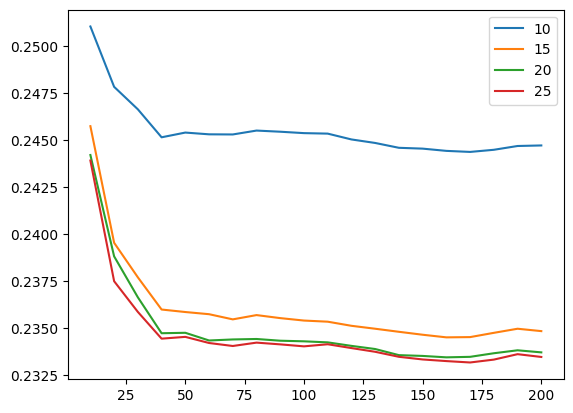

In [18]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

### Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [19]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [20]:
rf.feature_importances_

array([0.01529504, 0.03054242, 0.10281115, 0.08549299, 0.33501118,
       0.11071775, 0.25556166, 0.02823745, 0.01540529, 0.02092508])

In [21]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,households,0.015295
1,housing_median_age,0.030542
2,latitude,0.102811
3,longitude,0.085493
4,median_income,0.335011
5,ocean_proximity=INLAND,0.110718
6,ocean_proximity=LT 1H OCEAN,0.255562
7,population,0.028237
8,total_bedrooms,0.015405
9,total_rooms,0.020925


In [22]:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.335011
6,ocean_proximity=LT 1H OCEAN,0.255562
5,ocean_proximity=INLAND,0.110718
2,latitude,0.102811
3,longitude,0.085493


### Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

In [24]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(features))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(features))

In [25]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [26]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [27]:
scores = {}

In [28]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [29]:
scores['eta=0.3'] = parse_xgb_output(output)

In [30]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [31]:
scores['eta=0.1'] = parse_xgb_output(output)

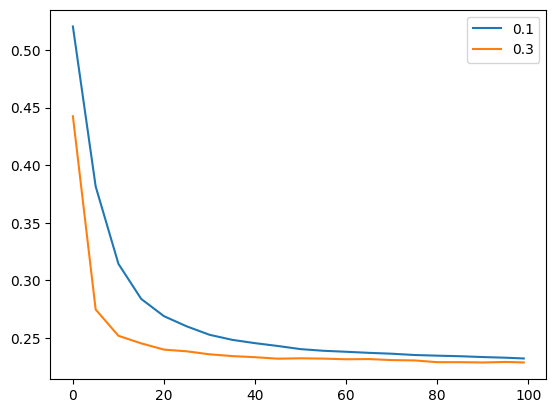

In [32]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.legend()